In [1]:
import os
# running from Root directory
os.chdir("..")

In [2]:
from motif_search_main import load_network_from_args
from utils.export_import import import_results
from utils.logs import log_motif_criteria_args, log_motif_results, log_sub_graph_args, log_randomizer_args, log_motifs_table
from utils.types import MotifCriteriaArgs, MotifType, MotifName, Motif
import matplotlib.pyplot as plt
import networkx as nx
from typing import Union
import numpy as np
from collections import defaultdict
from isomorphic.isomorphic import get_sub_graph_mapping_to_motif
from post_motif_analysis.network_utils import draw_sub_graph, draw_neighbors, node_properties
from matplotlib.patches import ArrowStyle 
import matplotlib.patches as patches
from networks.network import Network

In [3]:
data = import_results('results/cook_si2_herm_chem_k3_m5.bin')
data = import_results('results/cook_si2_herm_all_k3_m5_bio_rand.bin')


# data = import_results('results/pol_k3_m5.bin')
# data = import_results('results/cmpx_pol_k3_m5.bin')


# k = 4
# data = import_results('results/cook_si2_herm_chem_k4_m5.bin')
# data = import_results('results/durbin_herm_chem_k4_m5.bin')
# data = import_results('results/pol_k4_m10.bin')


# all: chem + gap
# data = import_results('results/cook_si2_herm_all_k3_m5.bin') # feed forward isnt a motif! (but makes sense due to gap + chem)
# data = import_results('results/cook_si2_herm_gap_k3_m5.bin') # feed forward isnt a motif! (but makes sense due to gap + chem)

# k =5
# data = import_results('results/cook_si2_herm_chem_k5_m10.bin')
# data = import_results('results/cook_si2_herm_all_k5_m10.bin')

# data = import_results('results/durbin_herm_chem_k3_m5.bin')

args = data['args']
motifs = data['motifs']

if args.input_network_file.startswith('../'):
    args.input_network_file = "/".join(args.input_network_file.strip("/").split('/')[1:])

network = load_network_from_args(args)

log_motif_criteria_args(MotifCriteriaArgs(**vars(args)))
log_sub_graph_args(args)
log_randomizer_args(args)
log_motif_results(motifs)
for motif in motifs.values():
    log_motifs_table([m for m in motif.polarity_motifs if m.motif_criteria.is_motif != MotifType.none])

Filtering Neurons of: herm
Filtering Synapses of type: chem
Network file name: SI 2 Synapse adjacency matrices.xlsx

Network properties:
	Neurons in the network: 272
	Participating Neurons (in the graph): 250

	Participating Nodes are neurons with at least: 5 synapses
	Synapses in the network: 9580
	Synapses in the graph: 5545
	Gaps in the network: 0
	Gaps in the graph: 0
	Nodes: 232
	Edges: 592
	Average clustering coefficient: 0.138
	Average shortest path (undirected): 2.624
	Density: 0.011
	Degree: Mean: 5.103 Std: 5.003 Median: 4.0 Max: 37 (node: AVAL)
	In-Degree: Mean: 2.552 Std: 3.674 Median: 1.0 Max: 26 (node: AVAL)
	Out-Degree: Mean: 2.552 Std: 2.296 Median: 2.0 Max: 12 (node: RIAR)

Motif criteria:
	alpha: 0.01
	use uniqueness: False
	uniqueness threshold: 3
	frequency threshold: 0.1

Sub graph enumeration algorithm: mfinder_i
Search using k: 3
Using isomorphic mapping: True
SIM sub graph search using max-control size: 1
Allow self loops: False
Full motif search: True

Randomiz

In [4]:
def plot_motif_distribution(motifs_, anti_motifs_, none_motifs_):
    sizes = [len(motifs_), len(anti_motifs_), len(none_motifs_)]
    labels = [MotifType.motif.value, MotifType.anti_motif.value, MotifType.none.value]

    fig, ax = plt.subplots()
    patches, texts, autotexts= ax.pie(sizes, labels=labels, autopct='%1.1f%%')

    total = sum(sizes)
    legend_lables = []
    for s,l in zip(sizes, labels):
        # legend_lables.append(f'{l} - {round(s*100/total, 2)}%')
        legend_lables.append(f'{l}: {s}/{total}')
        print(f'{l}: {s}/{total}')
        
    plt.axis('equal')
    plt.tight_layout()
    plt.legend(patches, legend_lables, title="motif type", loc='upper right')
    # plt.savefig('pol_dist.svg')

# plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)

In [5]:
def draw_motif(motif: Motif, ax):
    as_ = ArrowStyle("simple", head_length=1.5, head_width=2.5, tail_width=.4)
    ax.axis('off')

    motif_id = motif.id.replace('complex', 'c') if isinstance(motif.id, str) else motif.id
    title = f'{motif.name.value}-{motif_id}' if motif.name.value != MotifName.na else motif_id
    ax.set_title(title, fontsize=7.5)

    graph = nx.DiGraph(motif.role_pattern)
    pos = nx.circular_layout(graph)
    nx.draw_networkx(graph, pos, ax=ax, arrowsize=5, arrowstyle=as_)
    # nx.draw_networkx(graph, pos, ax=ax, node_color='red', arrowsize=5, arrowstyle=as_)
    
    if motif.polarity:
        for role, pol in zip(motif.role_pattern, motif.polarity):
            s,t = role
            graph[s][t]['polarity'] = 'c' if pol == 'complex' else pol

        edge_labels=nx.get_edge_attributes(graph, 'polarity')
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, ax=ax, font_color='k', font_weight='bold', label_pos=0.3)

In [6]:
def plot_motifs_z(motifs_list: list[Motif], motif_type: MotifType, top=10):
    if not len(motifs_list):
        return
        
    reverse_sort = True if motif_type == MotifType.motif else False
    sorted_by_z = sorted(motifs_list, key=lambda m: m.motif_criteria.z_score, reverse=reverse_sort)
    sorted_by_z = sorted_by_z[:top]

    z_scores = [abs(round(m.motif_criteria.z_score, 2)) for m in sorted_by_z]
    ids_ = [str(m.id) for m in sorted_by_z]
    ids_ = [i.replace('complex', 'c') for i in ids_]
    
    n_reals = [m.n_real for m in sorted_by_z]
    n_rands = [m.motif_criteria.n_rand for m in sorted_by_z]

    figure = plt.figure()
    figure.set_size_inches(top, 4)
    
    plt.title(f'Z-score of {motif_type.value}s')
    plt.ylabel('Z-score')
    plt.xlabel('Motif id')

    plt.bar(ids_, z_scores)
    # plt.xticks(ids_, ids_, rotation='vertical')
    # plt.xticks([], [])

    for x, y, n_real, n_rand in zip(ids_, z_scores, n_reals, n_rands):
       plt.text(x, y, f'n_real: {n_real}\nn_rand: {n_rand}', ha='center', fontsize=7.5)
    plt.show()
    
    # plot the graphs
    num_of_graphs = len(sorted_by_z)
    fig, ax = plt.subplots(nrows=1, ncols=num_of_graphs, figsize=(num_of_graphs*2.25, 2))
    fig.set_size_inches(num_of_graphs*2.25, 2)

    for idx, motif in enumerate(sorted_by_z):  
        ax_ = ax if num_of_graphs == 1 else ax[idx]
        draw_motif(motif, ax_)

In [7]:
three_sub_graphs_mapping = {
    14: "mutual out",
    38: "feed forward",
    46: "regulating mutual",
    74: "mutual in",
    78: "bi-mutual",
    102: "mutual cascade",
    108: "regulated mutual",
    110: "semi clique",
    6: "fan out",
    12: "cascade",
    36: "fan in",
    98: "feed backward",
    238: "clique"
}

In [8]:
def draw_graph_on_plot(graph, center_x, center_y, range_x, range_y, factor, ax):
    node_positions = nx.circular_layout(graph)

    for node in node_positions:
        x = node_positions[node][0]
        y = node_positions[node][1]
        
        new_x = x * range_x/factor + center_x
        new_y = y * range_y/factor + center_y
        node_positions[node] = (new_x, new_y)
        
    node_pos = [node_positions[v] for v in graph.nodes()]
    for node, pos in node_positions.items():
        ax.text(pos[0], pos[1], str(node), fontsize=10, ha='center', va='center')  # Node labels
    
    for u, v in graph.edges():
        ax.annotate("", xy=node_positions[v], xytext=node_positions[u],
                    arrowprops=dict(arrowstyle="->", linewidth=1.5, color='black'))
            
def scatter_motifs(motifs_, w_graph=False):
    z_scores = [m.motif_criteria.z_score for m in motifs_]
    n_reals = [m.n_real for m in motifs_]
    ids_ = [str(m.id) for m in motifs_]
    ids_ = [i.replace('complex', 'c') for i in ids_]
    pols = [m.polarity for m in motifs_]

    fig, ax = plt.subplots()
    plt.axhline(0, color='black', linestyle ="--")

    range_x = max(n_reals)
    range_y = max(z_scores) - min(z_scores)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    
    for i, (id_, x, y, m) in enumerate(zip(ids_, n_reals, z_scores, motifs_)):
        # color = 'r' if y < 0 else 'g'

        label = three_sub_graphs_mapping[int(id_)]
        id_num = id_.split()[0]
        id_pol = pols[i]
        label = f'{three_sub_graphs_mapping[int(id_num)]} {id_pol}'

        color_idx = list(three_sub_graphs_mapping.keys()).index(int(id_num))
        # print(label, color_idx)
        ax.scatter(x, y, label=label, color=colors[color_idx%10])
        
        # print(i, id_num, three_sub_graphs_mapping[int(id_num)], id_pol)
        if w_graph:
            graph = nx.DiGraph(m.role_pattern)
            draw_graph_on_plot(graph, x, y, range_x, range_y, 20, ax)

    # plt.title('Motifs and Anti-Motifs')
    plt.title("Polarity connectome's Motifs")
    plt.ylabel('Z-score')
    plt.xlabel('N-real')

    if w_graph:
        expand_x = 25 
        expand_y = 25
    
        ax.set_xlim([0-expand_x, max(n_reals) + expand_x])
        ax.set_ylim([min(z_scores)-expand_y, max(z_scores) + expand_y])

    lgd= ax.legend(loc='best', ncol=2, title="subgraph", fontsize=8, bbox_to_anchor=(1, 0.5))
    ax.grid(True)

    # plt.savefig('scatter.svg')
    # fig.savefig('scatter.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')



# poster
# scatter_motifs(motifs_[:8]+list(reversed(anti_motifs_)), True)
# scatter_motifs(motifs_, True)

In [9]:
def plot_motif_roles(motif: Motif, top=5):
    roles = motif.node_roles.keys()
    num_of_rows = len(roles)
    if num_of_rows == 0:
        print(f'n_real: {motif.n_real}')
        return
        
    fig, ax = plt.subplots(nrows=num_of_rows, ncols=1, figsize=(top, 4*num_of_rows))
    title = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
    fig.suptitle(f'Motif - {title}: node roles')
    fig.text(0.5, 0.01, 'Node name', ha='center', va='center', fontsize=10)
    fig.text(0.1, 0.5, 'Freqency', ha='center', va='center', rotation='vertical')

    for idx, role in enumerate(roles):
        nodes = list(motif.node_roles[role])[:top]
        freqs = list(motif.node_roles[role].values())[:top]
        ax_ = ax[idx]
        ax_.bar(nodes, freqs)
        ax_.set_title(f'role: {role}', fontsize=15)

    # single role - for presentations
    # fig = plt.figure()
    # role = 'c'
    # nodes = list(motif.node_roles[role])[:top]
    # freqs = list(motif.node_roles[role].values())[:top]
    # plt.bar(nodes, freqs)
    # plt.title(f"Role-{role} neurons")
    # plt.ylabel('Frequency')
    # plt.xlabel('Neuron')
    # fig.savefig(f'pol_78_role_{role}.svg')
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))
    draw_motif(motif, ax) 

def get_polarity_index(motif: Motif, polarity: list[str]):
    pol_ids = [m.polarity for m in motif.polarity_motifs]
    return pol_ids.index(polarity)

In [10]:
def get_motif_sub_graphs(motif: Motif, node = '', role = '', draw=True):
    if draw:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2, 2))
        draw_motif(motif, ax) 
    
    motif_name = f'{motif.name.value}-{motif.id}' if motif.name.value != MotifName.na else motif.id
    if node != "":
        print(f'Node "{node}" as role "{role}" - sub graphs in Motif {motif_name}:')
        node_idx = network.neuron_names.index(node) if isinstance(node, str) else node

    res = []
    for sub_graph in motif.sub_graphs:
        role_nodes_mapping = get_sub_graph_mapping_to_motif(sub_graph, motif.role_pattern, motif.polarity)
        if role != '' and role_nodes_mapping[role] != node_idx:
            continue

        if node != "" and node_idx not in role_nodes_mapping.values():
            continue
          
        if network.neuron_names:
            role_nodes_mapping_w_neuron_names = {k:network.neuron_names[role_nodes_mapping[k]] for k in role_nodes_mapping}
            
        print(role_nodes_mapping_w_neuron_names)
        res.append(role_nodes_mapping_w_neuron_names)
        
    return res

In [11]:
def node_props(node: Union[str, int], top=15):
    node_freq_in_motifs = {str(motif.id): motif.node_appearances.get(node, 0) for motif in motifs.values()}
    # filter only nodes that appear at least 1
    node_freq_in_motifs = {x: y for x, y in node_freq_in_motifs.items() if y != 0}

    freq_sorted = dict(sorted(node_freq_in_motifs.items(), key=lambda ele: ele[1], reverse=True))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(top, 4))
    ax.set_title(f'Appearance of node: {node} in sub-graphs')
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Sub-graph id')

    ax.bar(list(freq_sorted.keys())[:top], list(freq_sorted.values())[:top])
    node_properties(network, node)

In [12]:
def get_node_neighbors_in_motif(node: Union[str, int], motif: Motif, role=''):
    neighbors = set()
    node_idx = network.neuron_names.index(node) if isinstance(node, str) else node
    for subgraph in get_motif_sub_graphs(motif, node=node, role=role, draw=False):
        neighbors.update(set(list(subgraph.values())))
    if node in neighbors:
        neighbors.remove(node)
    return list(neighbors) 

def export_induced_graph(neighbors: list[str], output_name: str):
    neighbors_nodes = [network.neuron_names.index(n) for n in neighbors]
    induced_sub_graph = nx.induced_subgraph(network.graph, neighbors_nodes)
    
    induced_network = Network(synapse_threshold=args.synapse_threshold)
    induced_network.graph = induced_sub_graph
    induced_network.neuron_names = network.neuron_names
    induced_network.export_to_gephi(output_name)

In [13]:
# delete SIM subgraphs
del_sims = []
for m in motifs:
    if not isinstance(m, int):
        del_sims.append(m)

for m in del_sims:
    del motifs[m]
print(f'deleted sim: {del_sims}')

deleted sim: []


motif: 10/13
anti-motif: 1/13
none: 2/13


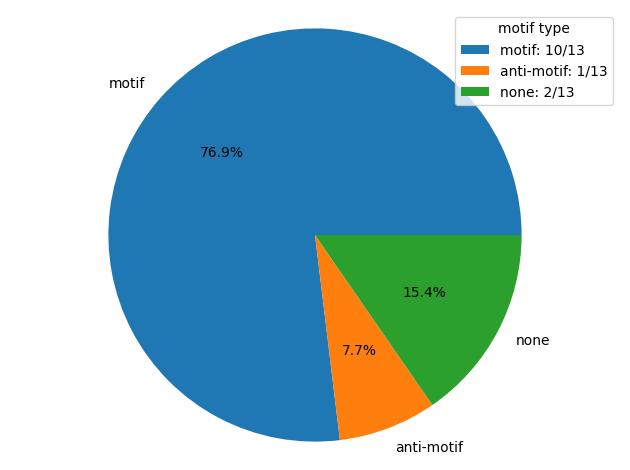

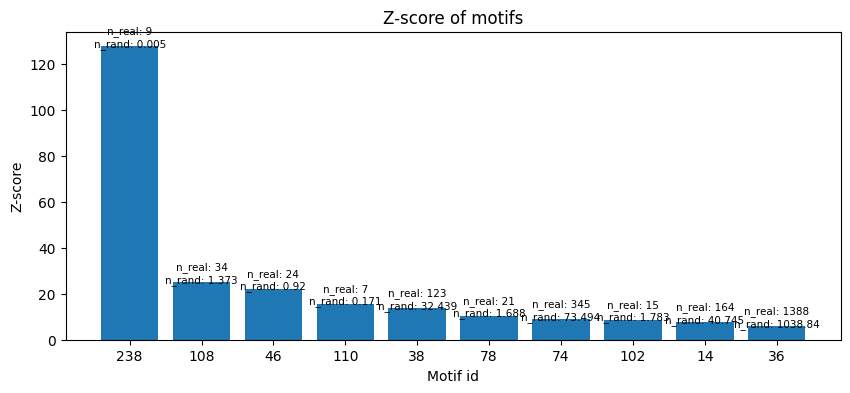

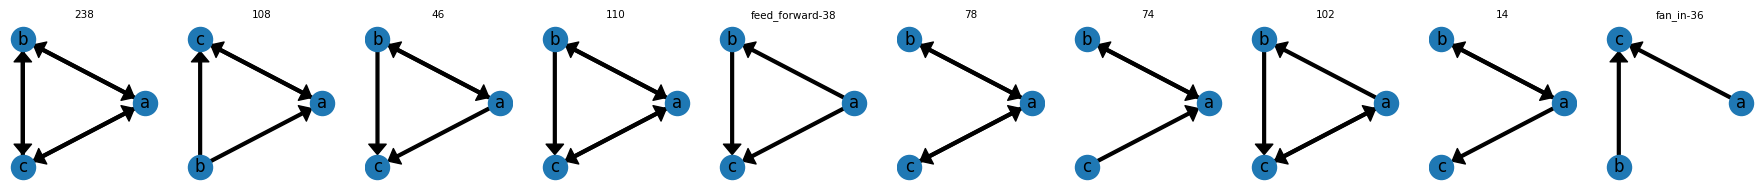

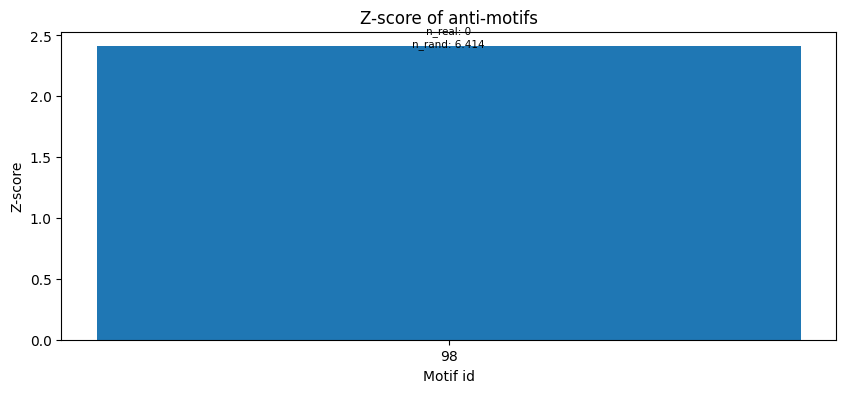

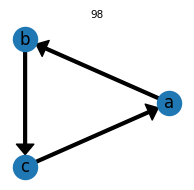

In [23]:
motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.motif]
anti_motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.anti_motif]
none_motifs_ = [m for m in motifs.values() if m.motif_criteria.is_motif == MotifType.none]

motifs_ = [m for m in motifs_ if m.n_real >= 1]
plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)
plot_motifs_z(motifs_, MotifType.motif, top=10)
plot_motifs_z(anti_motifs_, MotifType.anti_motif, top=10)

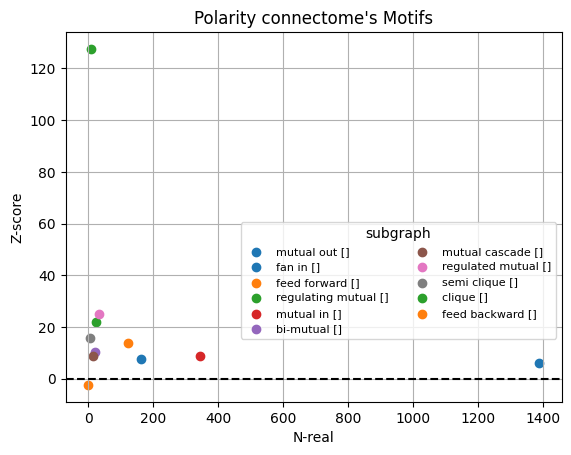

In [25]:
scatter_motifs(motifs_ + anti_motifs_, False)

In [16]:
node = 'AVDR'
neighbors = set()
for m in motifs_:
    if m.id != 38:
        continue
    neighbors.update(set(get_node_neighbors_in_motif(node, m, role='c')))


neighbors.add(node)
neighbors = list(neighbors)
draw_sub_graph(network, neighbors, False) #,center=node)
# export_induced_graph(neighbors, 'AVDR_38_c_m5.gexf')

Node "AVDR" as role "c" - sub graphs in Motif feed_forward-38:
empty graph


['ADFL', 'ASHL', 'BAGR', 'URXL', 'AQR', 'RIH', 'RIR', 'AIYL', 'AUAL', 'AIZL', 'RIAR', 'RMDL', 'RMDR', 'SMDDL', 'SMDVL', 'SMDVR', 'RIAR', 'RMDDL', 'RMDDR', 'RMDL', 'RMDR', 'RMDVL', 'RMDVR', 'SMDDL', 'SMDDR', 'SMDVL', 'SMDVR']


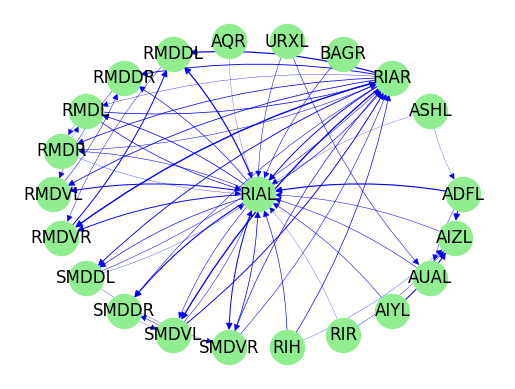

In [17]:
draw_neighbors(network, 'RIAL', 'all', True)
# n = ['ADAL', 'ADAR', 'ADLL', 'ADLR', 'AQR', 'ASHR', 'AVJR', 'DVC', 'FLPL', 'FLPR', 'LUAL', 'LUAR', 'PHBL', 'PHBR', 'PQR', 'PVDL', 'PVDR', 'AVDR', 'LUAR']
# export_induced_graph(n, 'RIAL_neighbors_pol_m5.gexf')

Polarity

In [18]:
def count_sim_polarity_motifs(show_all = False):
    sim_pol_motifs_amount = 0
    for m in motifs:
        if not isinstance(m, int):
            sim_motif = motifs[m]
            sim_pol_motifs_amount += len(sim_motif.polarity_motifs)
            if show_all:
                print(len(sim_motif.polarity_motifs))
                print([sm.id for sm in sim_motif.polarity_motifs])
    
    print('Total number of SIM pol motifs:', sim_pol_motifs_amount)
    
al_polarities = []
for m in motifs.values():
    al_polarities.extend(m.polarity_motifs)

motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.motif]
anti_motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.anti_motif]
none_motifs_ = [m for m in al_polarities if m.motif_criteria.is_motif == MotifType.none]

plot_motif_distribution(motifs_, anti_motifs_, none_motifs_)
count_sim_polarity_motifs()

motifs_ = [m for m in motifs_ if m.n_real >= 5]
plot_motifs_z(motifs_, MotifType.motif, top=23)
plot_motifs_z(anti_motifs_, MotifType.anti_motif, top=8)

C:\Users\dean\Documents\dev\network_motifs\network_motifs\venv\lib\site-packages\matplotlib\axes\_axes.py:3232: RuntimeWarning: invalid value encountered in divide
  x = x / sx


ValueError: cannot convert float NaN to integer

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ValueError: need at least one array to concatenate

<Figure size 640x480 with 1 Axes>

In [ ]:
scatter_motifs(motifs_, False)
scatter_motifs(anti_motifs_, False)

Check if a neuron appear in a specific motifs

In [ ]:
in_coherent_ffl_polarities = [
    ['+', '+', '-'],
    ['-', '-', '-'],
    ['+', '-', '+'],
    ['-', '+', '+'],
]
polarity = in_coherent_ffl_polarities[3]
pol_idx = get_polarity_index(motif_, polarity)
print('RIA' in motif_.polarity_motifs[pol_idx].node_appearances)
# motif_.polarity_motifs[pol_idx].node_appearances

In [ ]:
motif_ = motifs[78]
polarity = ['+', '+', '-', '-']
pol_idx = get_polarity_index(motif_, polarity)
plot_motif_roles(motif_.polarity_motifs[pol_idx], top=10)

In [ ]:
# k = 4
# motif_ = motifs[4428]
# polarity = ['-', '-', '-','+','+']

# motif_ = motifs[4374]
# polarity = ['+', '+', '-','-','-']

# motif_ = motifs[4678]
# polarity = ['+', '+', '-','-','-']

# motif_ = motifs[4424]
# polarity = ['+', '-','-','-']

# motif_ = motifs[4370]
# polarity = ['+', '-','-','-']

# motif_ = motifs[4436]
# polarity = ['-', '+', '+','-','+']

# motif_ = motifs[204]
# # polarity = ['-', '-', '-', '-']
# polarity = ['+', '-', '+', '-']
# polarity = ['+', '+', '+', '+']

# motif_ = motifs[904]
# polarity = ['+', '+', '-', '-']

# motif_ = motifs[206]
# polarity = ['+', '+', '+', '+', '+']

# motif_ = motifs[392]
# polarity = ['-','-','-']

# motif_ = motifs[404]
# polarity = ['-','+','+','+']

# motif_ = motifs[328]
# polarity = ['+','-','-']

# motif_ = motifs[2252]
# polarity = ['+', '+', '+', '+', '+']

# motif_ = motifs[2186]
# polarity = ['+', '+', '+', '+']

# motif_ = motifs[4420]
# polarity = ['-', '+', '-', '+']

# motif_ = motifs[344]
# polarity = ['+', '-', '-', '-']

# k = 3
motif_ = motifs[36]
polarity = ['-','-']

motif_ = motifs[38]
polarity = ['+','+', '+']
# polarity = ['-','-', '-']

# motif_ = motifs[74]
# polarity = ['+','-', '-']

# motif_ = motifs[108]
# polarity = ['-','+','+', '-']

pol_idx = get_polarity_index(motif_, polarity)
m = motif_.polarity_motifs[pol_idx]
print(m.motif_criteria)
plot_motif_roles(m, top=15)

In [ ]:
get_motif_sub_graphs(m)

In [ ]:
neighbors = get_node_neighbors_in_motif('PVCR', m, role='c')
neighbors.append('PVCR')
draw_sub_graph(network, neighbors, False)

In [ ]:
# k=3 ffls
draw_sub_graph(network, ['AVDR', 'ADLL', 'LUAL', 'AVAR'], False)
draw_sub_graph(network, ['AVBL', 'PVCL', 'PVCR', 'FLPR', 'FLPL'], False)


In [ ]:
#expansion of ffl
draw_sub_graph(network, ['PVCL', 'PVCR', 'FLPL', 'FLPR', 'AVBL', 'PVCL', 'AVBR'], False)

draw_sub_graph(network, ['SMDVR', 'RIAL', 'ADFL', 'SMDVL', 'RMDR', 'RMDL', 'RIH'], False)
draw_sub_graph(network, ['SMDVR', 'RIAR', 'ADFR', 'SMDVL', 'RMDR', 'RMDL', 'RIH'], False)


In [ ]:
# motif_ = motifs[78]
# polarity = ['+', '+', '-', '-']
# # polarity = ['complex', '-', 'complex', '+']
# pol_idx = get_polarity_index(motif_, polarity)
# plot_motif_roles(motif_.polarity_motifs[pol_idx], top=6)

In [ ]:
# get_motif_sub_graphs(motif_.polarity_motifs[pol_idx])

In [ ]:
draw_sub_graph(network, ['RIAL', 'SMDVL', 'SMDVR', 'SMDDL', 'SMDDR', 'RIAR'], False)

In [ ]:
draw_sub_graph(network, ['RIAL', 'RIAR', 'RMDDR', 'RMDVR', 'RMDDL', 'RMDVL'], False)

In [ ]:
draw_neighbors(network, 'AVEL', 'out', True)
draw_neighbors(network, 'AVEL', 'in', False)

In [ ]:
node_props('RIAL')